# Visualizing & Crossmatching your Light Curve

We have introduced two new classes into the `eleanor` package! This first is `eleanor.Visualize()`, which provides diagnostic tools for you to use to understand your light curves. The second is `eleanor.Crossmatch()`, which checks if your target was observed at 2-minute cadence, if the light curve is available from the TASOC pipeline, and if the light curve is available from Oelkers & Stassun (difference imaging).

We'll run through an example for both of these classes.

## Visualization Tutorial

We've created an `eleanor.Visualization()` class to help you understand what is going on with hyour light curves. If you have any additional tools you think would be useful in this class, please submit a pull request!

#### 1.1 Setting up the class

Initializing the `eleanor.visualization()` class is very simple! Once you have the light curve you are interested in, created with the `eleanor.TargetData()` class, you pass this into the visualization class! We'll run through an example with WASP-100.

In [1]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 15
import warnings
warnings.filterwarnings('ignore')

In [2]:
star = eleanor.Source(tic=38846515, sector=1, tc=True)
data = eleanor.TargetData(star)

Loading file hlsp_eleanor_tess_ffi_tic38846515_s01_tess_v2.0.5_lc.fits found on disk


In [3]:
vis = eleanor.Visualize(data)

#### 1.2 Overplotting your aperture

We provide a very simple function that overplots the aperture you use on the target pixel file.  You can also pass in your own aperture and change the color/linewidth of the plotted contour.

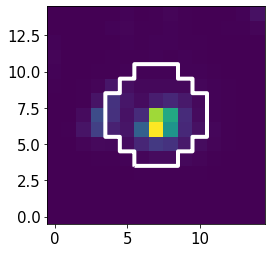

In [5]:
vis.aperture_contour()

Here's an example of changing the default aperture contour color and linewidth and also passing in a new aperture to plot:

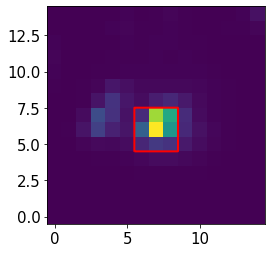

In [6]:
ap = np.zeros(data.tpf[0].shape)
ap[5:8,6:9] = 1
fig = vis.aperture_contour(aperture=ap, ap_color='r', ap_linewidth=2)

#### 1.3 Pixel-By-Pixel Light Curves

Another useful tool is what we call a pixel-by-pixel light curve. It's exactly what it sounds like: we plot the light curve for a single pixel across the sector. The default light curve that is plotted is the "corrected flux" for each pixel. You can simply call:

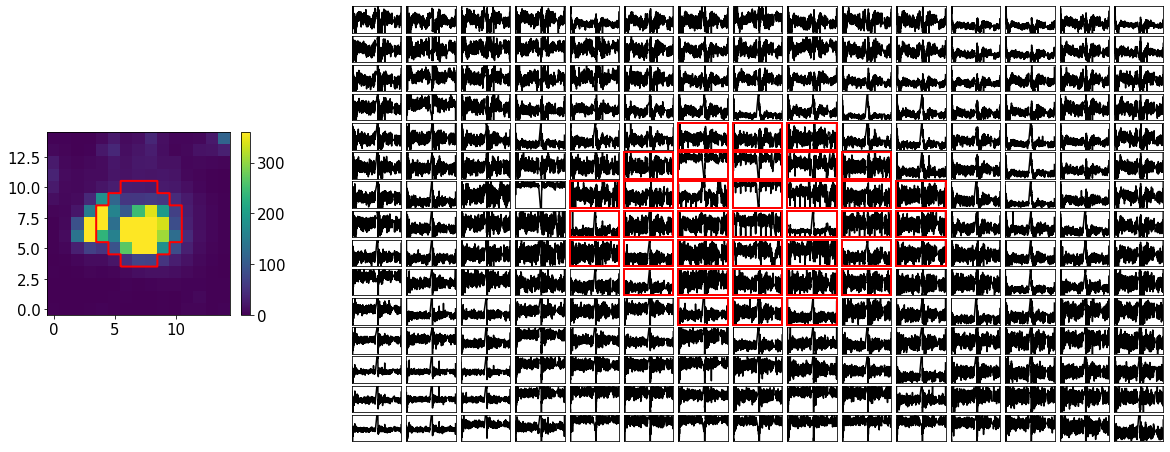

In [7]:
fig = vis.pixel_by_pixel()

Or you can specify which rows/columns you want to focus in on within the target pixel file:

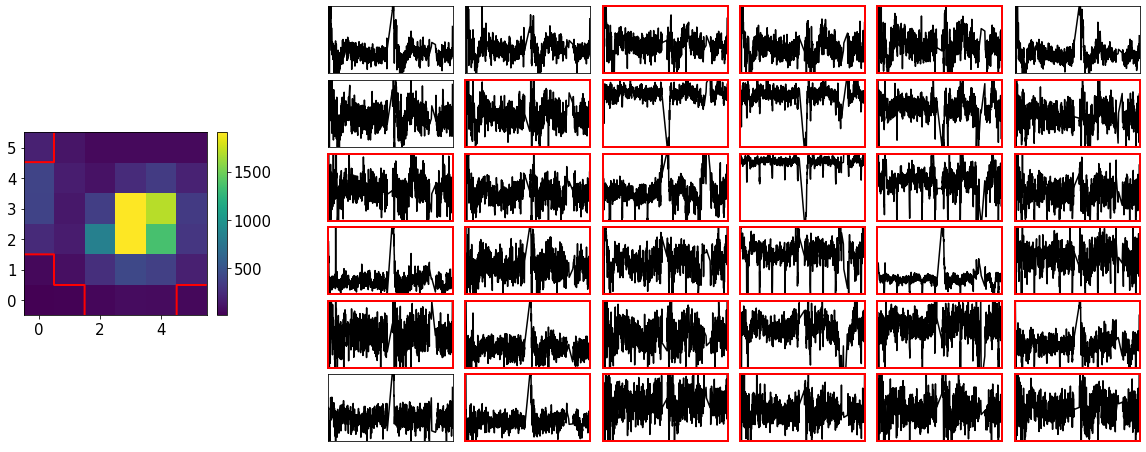

In [8]:
fig = vis.pixel_by_pixel(colrange=[4,10], rowrange=[4,10])

Or you can plot the raw flux light curve per each pixel (yay Earthshine!):

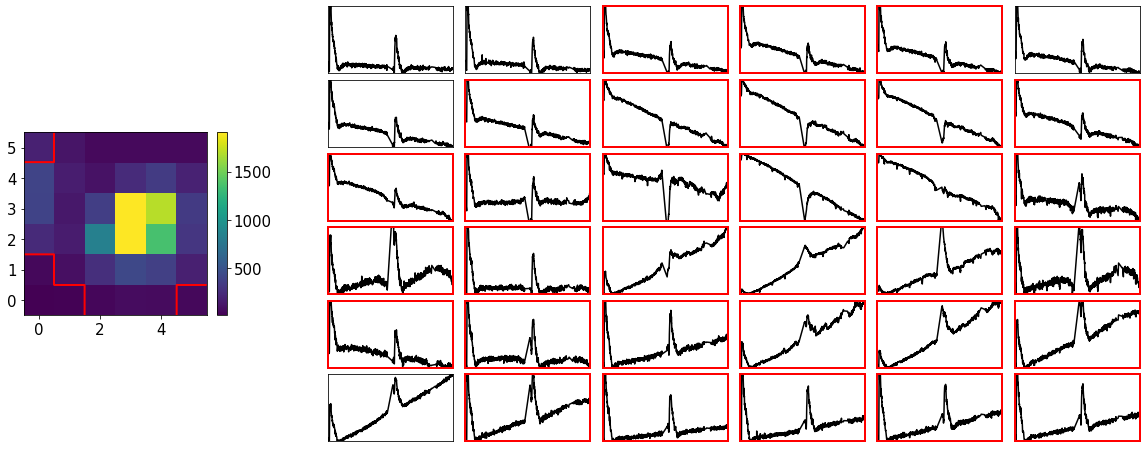

In [9]:
fig = vis.pixel_by_pixel(colrange=[4,10], rowrange=[4,10], data_type="raw")

Or you can plot a Lomb Scargle periodogram for each pixel AND you can color each light curve by the color of the associated pixel in the TPF plotted to the left:

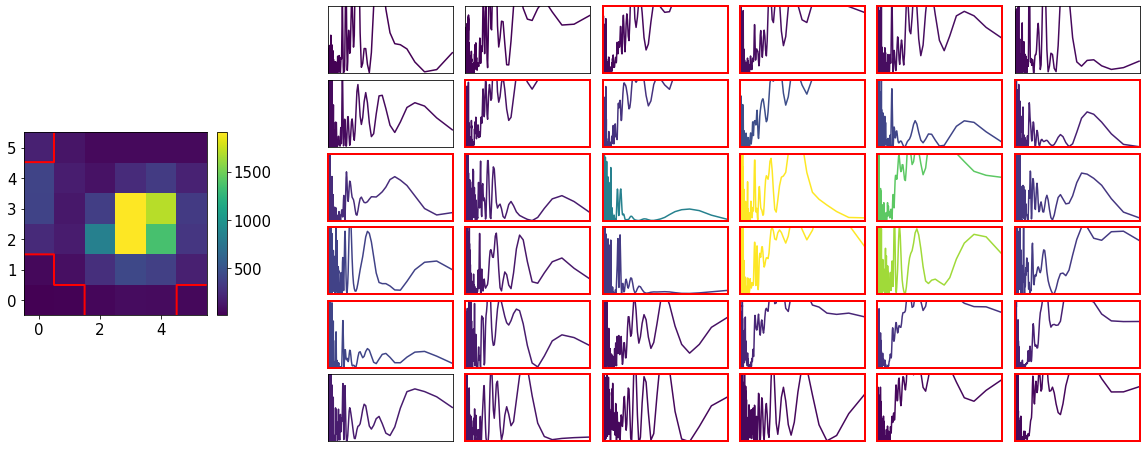

In [10]:
fig = vis.pixel_by_pixel(colrange=[4,10], rowrange=[4,10], data_type="periodogram",
                        color_by_pixel=True)

You can now overplot nearby Gaia sources on your TPF as well thanks to this handy tool from Nick Saunders.

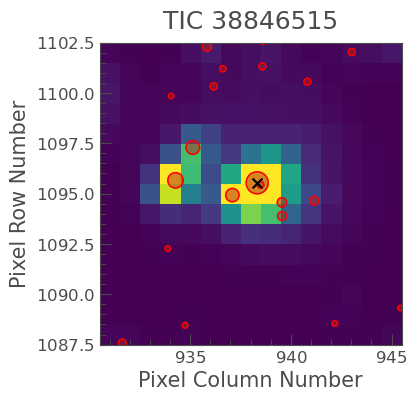

In [11]:
fig_gaia = vis.plot_gaia_overlay(magnitude_limit=19)

## Crossmatching

On to new things! It's important to check all of the light curves that are available for your target to make sure your astrophysical signal is indeed real. We've made this really easy for you to do by introducting a new `eleanor.Crossmatch()` class. Within this class, you can check if your target has been observed at either 2-minute cadence or is created by the TASOC or Oelkers & Stassun (2019) pipelines.

The `eleanor.Crossmatch()` class is initialized using an `eleanor.TargetData()` object.

In [15]:
cross = eleanor.Crossmatch(data)

The 2-minute function returns a list of `lightkurve.search.SearchResult` objects if your target has been observed in this mode. Users also have the option to set `download=True`, which then returns a list of `lightkurve.lightcurve.TessLightCurve` objects. You also have the option to specify which sectors you want to search/download!

In [16]:
cross.two_minute()

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,38846515,0.0
1,TESS Sector 01,2018,TESS-SPOC,1800,38846515,0.0


In [17]:
lcs = cross.two_minute(download=True)

#### TASOC pipeline

The TESS Asteroseismic Consortium (TASC) is providing light curves for the community to use that are tailored towards finding asteroseismic signals. Callingn `eleanor.Crossmatch.tasoc_lc()` searches MAST to find if these light curves are available. For more information on the TASOC light curves, see https://archive.stsci.edu/hlsp/tasoc.

In [18]:
cross.tasoc_lc()

The TASOC light curves have their own quality flags called `eleanor.Crossmatch.tasoc_pixel_quality`. We can apply these quality flags to the light curve and see that the WASP-100b transits are recovered really nicely! 

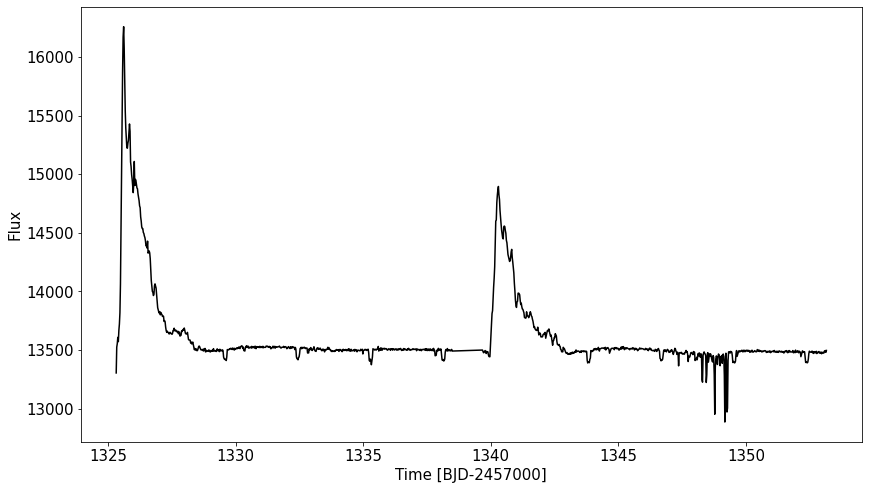

In [19]:
plt.figure(figsize=(14,8))

q = cross.tasoc_pixel_quality == 0
plt.plot(cross.tasoc_time[q], cross.tasoc_flux_raw[q], 'k')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Flux');

#### Oelkers & Stassun pipeline

Additionally, the Vanderbilt team is providing light curves for stars in the FFIs via difference imaging. 

In [17]:
cross.oelkers_lc()

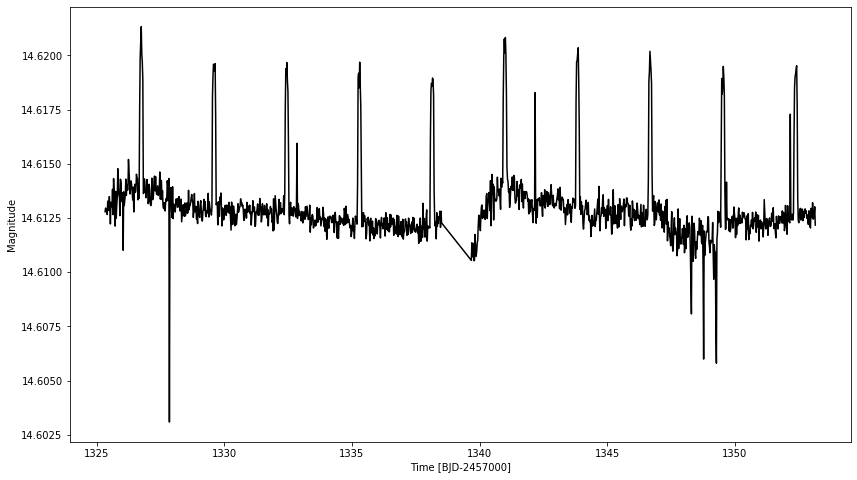

In [18]:
plt.figure(figsize=(14,8))
plt.plot(cross.os_time, cross.os_mag, 'k')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Magnitude');

We can now plot all light curves on the same plot and compare. All of the transits pop out really nicely! This (and the fact that WASP-100 has already been confirmed) is very reassuring that our transits are indeed real.

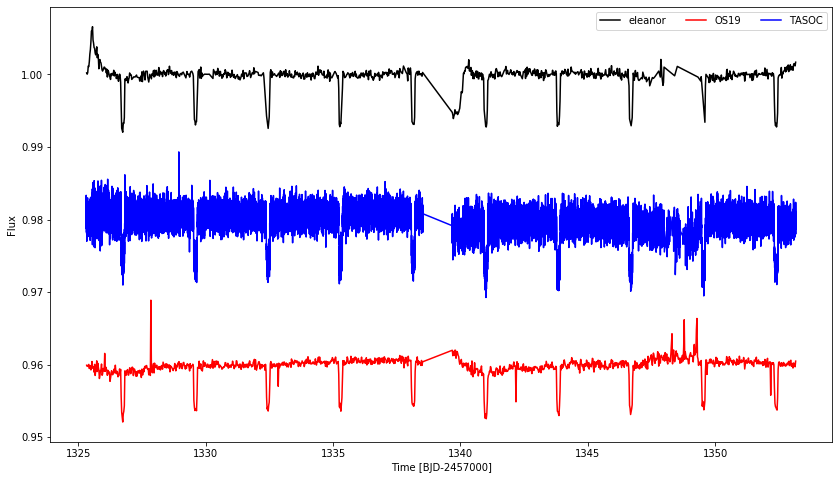

In [19]:
plt.figure(figsize=(14,8))

e = data.quality == 0
plt.plot(data.time[e], data.corr_flux[e]/np.nanmedian(data.corr_flux[e]), 
         'k', label='eleanor')

plt.plot(cross.os_time, 
         10**(-0.4*cross.os_mag)/np.nanmedian(10**(-0.4*cross.os_mag))-0.04, 
         'r', label='OS19')

plt.plot(cross.tasoc_time[q], 
         cross.tasoc_flux_raw[q]/np.nanmedian(cross.tasoc_flux_raw[q])-0.02, 
         'b', label='TASOC')

plt.legend(ncol=3)

plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Flux');